In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.utils import *
from data_causl.data import *
from frengression import *

device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
import src.exp_utils as exp_utils

from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform
import warnings

warnings.filterwarnings("ignore")


In [2]:
s, x,z,y= generate_data_longitudinl(n=6000,T=5)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s = torch.tensor(s, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)

2.067551403528454


# joint time trajectory

In [2]:
s, x,z,y= generate_data_survivl(n=30000,T=5)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s = torch.tensor(s, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)

2.0909338076738213


In [3]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(x=x,z=z,y=y,num_iters=6000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 5.5437,	loss_y 3.4944, 3.5384, 0.0880,	loss_eta 2.0492, 2.1346, 0.1708
Epoch 1000: loss 2.9736,	loss_y 1.4667, 2.9312, 2.9289,	loss_eta 1.5069, 2.9905, 2.9672
Epoch 2000: loss 2.9709,	loss_y 1.4652, 2.9268, 2.9232,	loss_eta 1.5057, 2.9971, 2.9829
Epoch 3000: loss 2.9684,	loss_y 1.4679, 2.9295, 2.9231,	loss_eta 1.5005, 2.9939, 2.9869
Epoch 4000: loss 2.9674,	loss_y 1.4634, 2.9316, 2.9364,	loss_eta 1.5040, 3.0076, 3.0071
Epoch 5000: loss 2.9677,	loss_y 1.4615, 2.9236, 2.9241,	loss_eta 1.5061, 3.0052, 2.9981
Epoch 6000: loss 2.9666,	loss_y 1.4616, 2.9313, 2.9394,	loss_eta 1.5050, 2.9975, 2.9849


In [4]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1,1,1,1,1]]), sample_size=1000)

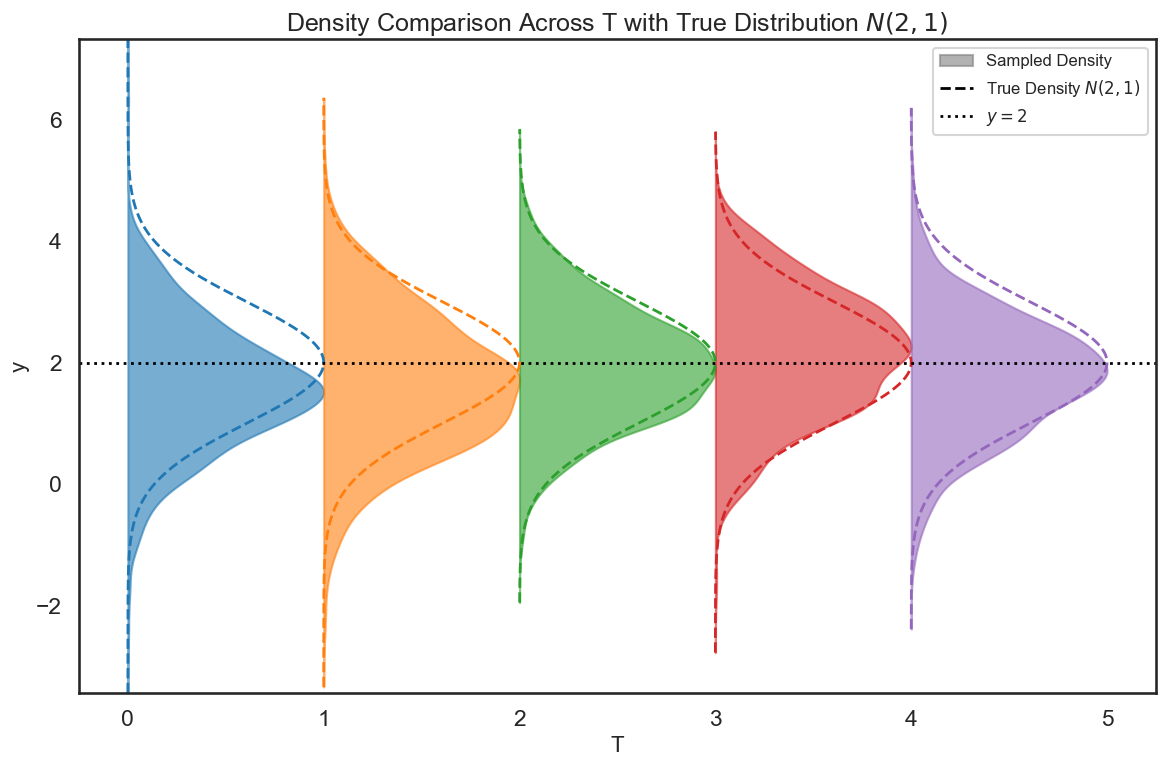

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(5)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()


In [7]:
s, x,z,y= generate_data_survivl(n=30000,T=10)
print(np.mean(y[x[:,0]==1,0])-np.mean(y[x[:,0]==0,0]))
s = torch.tensor(s, dtype=torch.float32)
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
z = torch.tensor(z, dtype=torch.float32)
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=10, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(x=x,z=z,y=y,num_iters=8000, lr=1e-4, print_every_iter=1000)

2.0909338076738213
Epoch 1: loss 8.0583,	loss_y 5.0842, 5.1553, 0.1421,	loss_eta 2.9741, 3.0997, 0.2511
Epoch 1000: loss 4.3088,	loss_y 2.1291, 4.2484, 4.2386,	loss_eta 2.1797, 4.3538, 4.3480
Epoch 2000: loss 4.2984,	loss_y 2.1254, 4.2412, 4.2316,	loss_eta 2.1730, 4.3427, 4.3395
Epoch 3000: loss 4.2965,	loss_y 2.1118, 4.2236, 4.2236,	loss_eta 2.1847, 4.3517, 4.3339
Epoch 4000: loss 4.2854,	loss_y 2.1094, 4.2266, 4.2345,	loss_eta 2.1761, 4.3497, 4.3473
Epoch 5000: loss 4.2905,	loss_y 2.1123, 4.2234, 4.2223,	loss_eta 2.1782, 4.3393, 4.3221
Epoch 6000: loss 4.2896,	loss_y 2.1006, 4.2067, 4.2123,	loss_eta 2.1890, 4.3431, 4.3082
Epoch 7000: loss 4.2689,	loss_y 2.0857, 4.1842, 4.1969,	loss_eta 2.1832, 4.3365, 4.3067
Epoch 8000: loss 4.2655,	loss_y 2.0784, 4.1726, 4.1885,	loss_eta 2.1872, 4.3359, 4.2974


In [ ]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1,1,1,1,1]]), sample_size=1000)

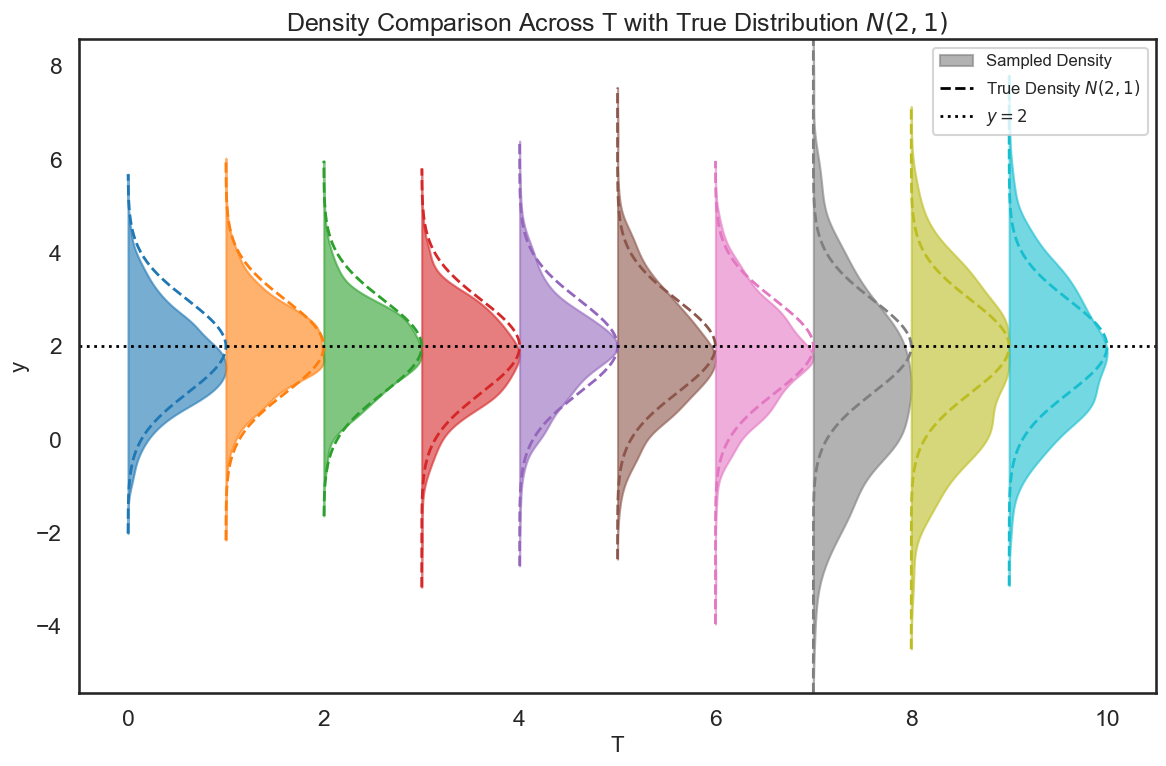

In [24]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1]*10]), sample_size=1000)
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(10)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()


# single time point

In [10]:
model = FrengressionSeq(x_dim=1, y_dim=1, z_dim=1, T=5, s_dim = 1, noise_dim=1, num_layer=3, hidden_dim=100, device=device, x_binary = True)
# model.train_xz(x=x, z=z, y=y, s=s, num_iters=6000, lr=1e-4, print_every_iter=1000)
model.train_y(x=x,z=z,y=y,num_iters=10000, lr=1e-4, print_every_iter=1000)

Epoch 1: loss 5.5204,	loss_y 3.4596, 3.5151, 0.1110,	loss_eta 2.0609, 2.1409, 0.1600
Epoch 1000: loss 2.9881,	loss_y 1.4675, 2.9241, 2.9131,	loss_eta 1.5206, 3.0040, 2.9667
Epoch 2000: loss 2.9795,	loss_y 1.4572, 2.9072, 2.9000,	loss_eta 1.5223, 3.0212, 2.9978
Epoch 3000: loss 2.9669,	loss_y 1.4533, 2.9084, 2.9102,	loss_eta 1.5136, 3.0071, 2.9870
Epoch 4000: loss 2.9451,	loss_y 1.4385, 2.8849, 2.8928,	loss_eta 1.5067, 2.9913, 2.9693
Epoch 5000: loss 2.9303,	loss_y 1.4317, 2.8687, 2.8741,	loss_eta 1.4986, 2.9760, 2.9547
Epoch 6000: loss 2.9303,	loss_y 1.4230, 2.8496, 2.8533,	loss_eta 1.5073, 2.9744, 2.9342
Epoch 7000: loss 2.9290,	loss_y 1.4132, 2.8184, 2.8104,	loss_eta 1.5159, 2.9816, 2.9314
Epoch 8000: loss 2.9059,	loss_y 1.4012, 2.8007, 2.7991,	loss_eta 1.5048, 2.9792, 2.9489
Epoch 9000: loss 2.8748,	loss_y 1.3751, 2.7613, 2.7724,	loss_eta 1.4996, 2.9620, 2.9248
Epoch 10000: loss 2.8589,	loss_y 1.3622, 2.7353, 2.7462,	loss_eta 1.4967, 2.9345, 2.8755


In [ ]:
y_margin_sample = model.sample_causal_margin(x = torch.tensor([[1,1,1,1,1]]), sample_size=1000)

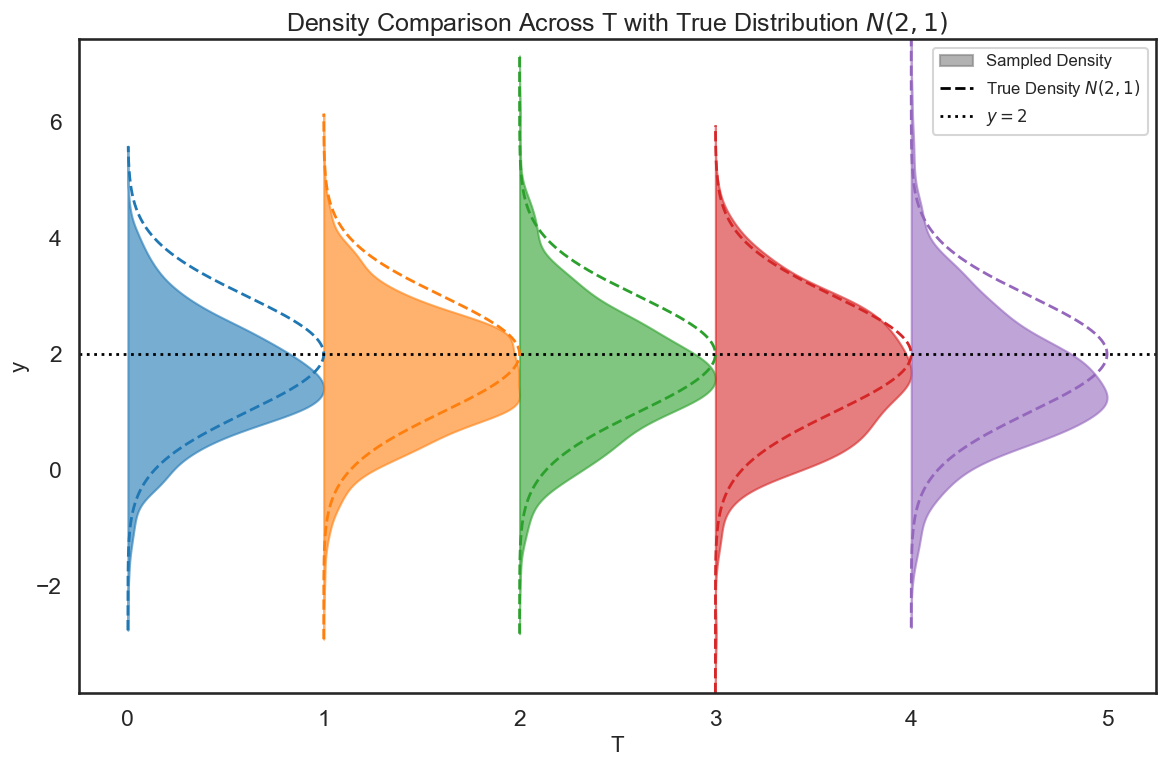

In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, gaussian_kde
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import copy


# Convert torch tensors to numpy arrays
y_lists_np = copy.deepcopy([y.view(-1).numpy() for y in y_margin_sample])

# Define the true density parameters
true_mu = 2
true_sigma = 1

# Set the style for seaborn
sns.set(style="white", context="talk")

# Define T values
T_values = range(5)  # 0,1,2,3,4

# Define colors for each T using a color palette
palette = sns.color_palette("tab10", len(T_values))  # 'tab10' provides distinct colors

# Initialize the plot
plt.figure(figsize=(12, 8))

# Iterate over each T and corresponding y list
for idx, (T, y) in enumerate(zip(T_values, y_lists_np)):
    # Compute the kernel density estimate for the y data
    kde = gaussian_kde(y)
    
    # Define y values for the density plot
    y_min = y.min() - 1
    y_max = y.max() + 1
    y_values = np.linspace(y_min, y_max, 1000)
    
    # Compute the density
    density = kde(y_values)
    
    # Normalize the density for better visualization
    density_norm = density / density.max()
    
    # Plot the sampled density as a filled area
    plt.fill_betweenx(y_values, T, density_norm + T, color=palette[idx], alpha=0.6)
    
    # Compute the true density N(2,1)
    true_density = norm.pdf(y_values, loc=true_mu, scale=true_sigma)
    true_density_norm = true_density / true_density.max()
    
    # Plot the true density as a dashed line
    plt.plot(T + true_density_norm, y_values, color=palette[idx], linestyle='--', linewidth=2)

# Add the vertical line at y=2 across all T
plt.axhline(y=2, color='black', linestyle=':', linewidth=2, label='$y=2$')

# Labels and title
plt.xlabel('T', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.title('Density Comparison Across T with True Distribution $N(2,1)$', fontsize=18)

# Create a custom legend
legend_elements = [
    Patch(facecolor='grey', edgecolor='grey', alpha=0.6, label='Sampled Density'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=2, label='True Density $N(2,1)$'),
    Line2D([0], [0], color='black', linestyle=':', linewidth=2, label='$y=2$')
]

plt.legend(handles=legend_elements, fontsize=12, loc='upper right')

# Adjust y-axis limits
y_all = np.concatenate(y_lists_np)
plt.ylim(y_all.min() - 1, y_all.max() + 1)

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()
